In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import conda_installer
from rdkit import Chem
from deepchem.feat.graph_features import atom_features as get_atom_features
import rdkit
import pickle
import matplotlib.pyplot as plt
import deepchem as dc

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'dgl'
Skipped loading some Jax models, missing a dependency. No module named 'haiku'


In [2]:
PDBs = pickle.load(open('PDBs_RDKit.pkl', 'rb'))
PDBs_BRD4 = pickle.load(open('PDBs_BRD4.pkl', 'rb'))
df = pd.read_csv('T_data.csv')

In [3]:
# del df['Unnamed: 0']

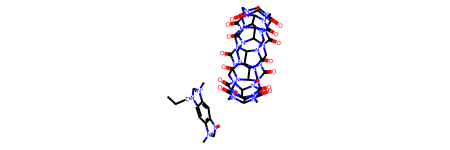

In [23]:
PDBs['Sampl3_h1_and_2_host2--guest8']

In [5]:
len(PDBs)

103

In [6]:
len(PDBs_BRD4)

6

In [7]:
PDBs_BRD4

{'BRD4_p4a_tleap--ligand-3': <rdkit.Chem.rdchem.Mol at 0x31fec8360>,
 'BRD4_p4a_tleap--ligand-5': <rdkit.Chem.rdchem.Mol at 0x31fecd800>,
 'BRD4_p4a_tleap--ligand-6': <rdkit.Chem.rdchem.Mol at 0x31f89dbc0>,
 'BRD4_p4a_tleap--ligand-7': <rdkit.Chem.rdchem.Mol at 0x31eb97ce0>,
 'BRD4_p4a_tleap--ligand-8': <rdkit.Chem.rdchem.Mol at 0x31fecda30>,
 'BRD4_p4a_tleap--ligand-9': <rdkit.Chem.rdchem.Mol at 0x31fecdb20>}

In [8]:
training_cols = ['TS_comp', 'TS_host', 'TS_ligand']

In [9]:
featurizer = dc.feat.ConvMolFeaturizer(per_atom_fragmentation=False)
TRAIN_SET = 0.8

In [10]:
X = []
X_ids = []
# one_add = 0 if len(PDBs.keys()) % 2 == 0 else 1
for k in PDBs.keys():
    X_ids.append(k)
    X.append(featurizer.featurize(PDBs[k]))
split_index = int(len(X) * TRAIN_SET)
X = [x[0] for x in X]
X_train_featurized = X[:split_index]
X_test_featurized = X[split_index:]

In [11]:
pdb_names = [i for i in X_ids]
pdb_names_train = pdb_names[:split_index]
pdb_names_test = pdb_names[split_index:]

In [12]:
x_add_train, x_add_test, y_train, y_test = [], [], [], []
for i in range(len(pdb_names_train)):
    new_df = df[(df['Id'] == pdb_names_train[i])]
    y_train.append(new_df['exp'].to_numpy()[0])
    x_add_train.append(-new_df[training_cols].to_numpy()[0])
y_train = np.array(y_train)
    
for i in range(len(pdb_names_test)):
    new_df = df[(df['Id'] == pdb_names_test[i])]
    y_test.append(new_df['exp'].to_numpy()[0])
    x_add_test.append(-new_df[training_cols].to_numpy()[0])
y_test = np.array(y_test)

# Input preparation

In [13]:
from deepchem.metrics import to_one_hot
from deepchem.feat.mol_graphs import ConvMol

x_preprocessed_train, x_preprocessed_test = [], []

## for X train
multiConvMol = ConvMol.agglomerate_mols(X_train_featurized)
x_preprocessed_train = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
    x_preprocessed_train.append(multiConvMol.get_deg_adjacency_lists()[i])
x_preprocessed_train.append(np.array(x_add_train))

## for X test
multiConvMol = ConvMol.agglomerate_mols(X_test_featurized)
x_preprocessed_test = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
    x_preprocessed_test.append(multiConvMol.get_deg_adjacency_lists()[i])
x_preprocessed_test.append(np.array(x_add_test))

In [14]:
x_train = np.full([14, np.max([v.shape[0] for v in x_preprocessed_train]),
                  np.max([v.shape[1] for v in x_preprocessed_train if len(v.shape) > 1])], 1.123456)
for i,j in enumerate(x_preprocessed_train):
    if len(j.shape) > 1:
        x_train[i][:j.shape[0],:j.shape[1]] = np.array(j)
    else:
        x_train[i][:len(j), :1] = np.array(j).reshape(j.shape[0], 1)
x_train = x_train.reshape([1] + list(x_train.shape))

x_test = np.full([14, np.max([v.shape[0] for v in x_preprocessed_test]),
                  np.max([v.shape[1] for v in x_preprocessed_test if len(v.shape) > 1])], 1.123456)
for i,j in enumerate(x_preprocessed_test):
    if len(j.shape) > 1:
        x_test[i][:j.shape[0],:j.shape[1]] = np.array(j)
    else:
        x_test[i][:len(j), :1] = np.array(j).reshape(j.shape[0], 1)
x_test = x_test.reshape([1] + list(x_test.shape))

In [31]:
x_train.shape

(1, 14, 8601, 75)

In [32]:
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
import tensorflow.keras.backend as K
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Concatenate
from tensorflow.keras import initializers
import sys
import tensorflow as tf
import random


class GBGraphConvModel(tf.keras.Model):

  def modify_graphgather(self, batch_size):
    self.readout.batch_size = batch_size
    self.batch_size = batch_size
    
  def __init__(self, batch_size):
    super(GBGraphConvModel, self).__init__()
    self.input_shapes = None
    self.batch_size = batch_size
    self.gc1 = GraphConv(64, activation_fn=tf.nn.tanh)
    self.batch_norm1 = layers.BatchNormalization()
    self.gp1 = GraphPool()

    self.gc2 = GraphConv(64, activation_fn=tf.nn.tanh)
    self.batch_norm2 = layers.BatchNormalization()
    self.gp2 = GraphPool()

    self.dense1 = layers.Dense(128, activation=tf.nn.tanh)
    self.batch_norm3 = layers.BatchNormalization()
    self.readout = GraphGather(batch_size=self.batch_size, activation_fn=tf.nn.tanh)

    self.dense2 = layers.Dense(64, activation=tf.nn.sigmoid)
    self.dense3 = layers.Dense(1)
    
    ## Dense for overall
    self.dense4 = layers.Dense(1, 
     kernel_initializer=initializers.Constant([.5, -1, 1, 1]),
     bias_initializer=initializers.Zeros())
    ## TODO: check the coeffients match with the info
    # self.dense4 = layers.Dense(1, 
    #      kernel_initializer=initializers.Constant([.5, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1]),
    #      bias_initializer=initializers.Zeros(), activation=tf.keras.activations.relu)

  def call(self, inputs):
#     x_feat, x_add = inputs[0], inputs[1]
    inputs = inputs[0]
    x = []
#     input_shapes = [[4822, 75], [11, 2], [4822], [1142, 1], [1635, 2], [2042, 3],
#                    [3, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10]]
    for i in range(len(self.input_shapes)):
        x.append(tf.reshape(inputs[i][inputs[i] != 1.123456], self.input_shapes[i]))
    for i in range(1, len(self.input_shapes)):
        x[i] = tf.cast(x[i], tf.int32)
    x_add = tf.reshape(inputs[13][inputs[13] != 1.123456], [self.batch_size, 3])

    gc1_output = self.gc1(x)
    batch_norm1_output = self.batch_norm1(gc1_output)
    gp1_output = self.gp1([batch_norm1_output] + x[1:])

    gc2_output = self.gc2([gp1_output] + x[1:])
    batch_norm2_output = self.batch_norm1(gc2_output)
    gp2_output = self.gp2([batch_norm2_output] + x[1:])

    dense1_output = self.dense1(gp2_output)
    batch_norm3_output = self.batch_norm3(dense1_output)
    readout_output = self.readout([batch_norm3_output] + x[1:])
    
    model_var = self.dense2(readout_output)
    model_var = self.dense3(model_var)
    binding_affinity = tf.concat([model_var, x_add], axis=1)
    ddg = self.dense4(binding_affinity)
    host_entropy = x_add[1]

#     tf.print(self.dense4.weights, output_stream="file://weights.txt", summarize=30)
#     tf.print(binding_affinity[0], output_stream="file://binding_a.txt", summarize=30)
#     tf.print(ddg[0], output_stream="file://ddg.txt")
#     tf.print(model_var, output_stream="file://model_var.txt", summarize=30)
#     tf.print("-------------------------", output_stream=sys.stdout)
    return model_var, host_entropy


def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred[0] - y_true + y_pred[1]))) 
model = GBGraphConvModel(split_index)
model.compile(optimizer = "adam", loss = root_mean_squared_error)
#K.set_value(model.optimizer.learning_rate, 0.001)

In [33]:
model.input_shapes = [i.shape for i in x_preprocessed_train]
history = model.fit(x_train, y_train.reshape([1, -1]), epochs=30)

Epoch 1/30


/Users/libinathomas/miniforge3/lib/python3.10/site-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'gb_graph_conv_model_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/libinathomas/miniforge3/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 2.3115
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 2.0282
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 2.1010
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 2.0715
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 2.0258
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.0271
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 2.0260
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.0294
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 2.0257
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 2.0269
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.0248
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 2.0245
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.0262
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 2.0255
Epoch 15/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 2.0244
Epoch 16/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/st

In [17]:
len(pdb_names_test)

21

In [18]:
model.input_shapes = [i.shape for i in x_preprocessed_test]
model.modify_graphgather(21)
pred = model.predict(x_test)
model.evaluate(x_test, y_test.reshape([1, -1]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 1.2974


1.297391653060913

## for BRD4

In [36]:
X = []
y = []
info = []
for i,pdb in enumerate(list(PDBs.keys())):
    info.append(df[df['Id'] == pdb][['TS_comp', 'TS_host', 'TS_ligand']].to_numpy()[0])
for i,pdb in enumerate(list(PDBs.keys())):
    X.append(featurizer.featurize(PDBs[pdb])[0])
    y.append(df[df['Id'] == pdb]['exp'].to_numpy()[0])

In [34]:
weights, biases = model.dense4.get_weights()

# Print the weights and biases
print("Weights of dense4 (coefficients):", weights)
print("Biases of dense4:", biases)

Weights of dense4 (coefficients): [[ 0.5 -1.   1.   1. ]
 [ 0.5 -1.   1.   1. ]
 [ 0.5 -1.   1.   1. ]
 [ 0.5 -1.   1.   1. ]]
Biases of dense4: [0.]


In [16]:
X_brd4 = []
y_brd4 = []
info_brd4 = []

# Iterate over the PDBs_BRD4 keys
for i, pdb in enumerate(list(PDBs_BRD4.keys())):
    # Check if pdb exists in the DataFrame
    filtered_df = df[df['Id'] == pdb]
    
    # Only append if the DataFrame is not empty
    if not filtered_df.empty:
        info_brd4.append(filtered_df[['TS_comp', 'TS_host', 'TS_ligand']].to_numpy()[0])
        X_brd4.append(featurizer.featurize(PDBs_BRD4[pdb])[0])
        y_brd4.append(filtered_df['exp'].to_numpy()[0])
    else:
        print(f"Warning: {pdb} not found in DataFrame 'df'. Skipping...")

# Continue with the rest of the processing...


# 